<a href="https://colab.research.google.com/github/elip06/filecoin-electricity-model/blob/main/Filecoin_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from functools import reduce
import pandas as pd
import numpy as np
from matplotlib.pyplot import cm
from cycler import cycler
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns

## Analysis of Miner Size of Current System

In [ ]:
url = "https://api.spacescope.io/v2/storage_provider/power"
payload={}
headers = {
  'authorization': 'Bearer <--Please replace your API key here-->'
}
response = requests.request("GET", url, headers=headers, data=payload)

In [ ]:
miner_array = json.loads(response.text)['data']

In [ ]:
miners_raw_byte_power = [m['raw_byte_power'] for m in miner_array]
# remove miners with 0 bytes of storage
miners_non_zero_raw_byte_power = [m for m in miners_raw_byte_power if m != 0]
miners_non_zero_raw_byte_power_TB = [m/1e+12 for m in miners_non_zero_raw_byte_power]
miners_non_zero_raw_byte_power_TB.sort()

In [ ]:
small_miners = [m for m in miners_non_zero_raw_byte_power_TB if m <= 1000]
num_small_miners= len(small_miners)
mid_miners = [m for m in miners_non_zero_raw_byte_power_TB if m > 1000 and m <= 50000]
num_mid_miners= len(mid_miners)
big_miners = [m for m in miners_non_zero_raw_byte_power_TB if m > 50000]
num_big_miners= len(big_miners)

In [ ]:
accumulated_rbp = []
total_rbp_tb = sum(miners_non_zero_raw_byte_power_TB)
prev_c = 0
counts = [num_small_miners, num_mid_miners, num_big_miners]

In [ ]:
for c in counts:
  current_c = prev_c + c
  accumulated_rbp.append(sum(miners_non_zero_raw_byte_power_TB[prev_c:current_c]))
  prev_c = current_c

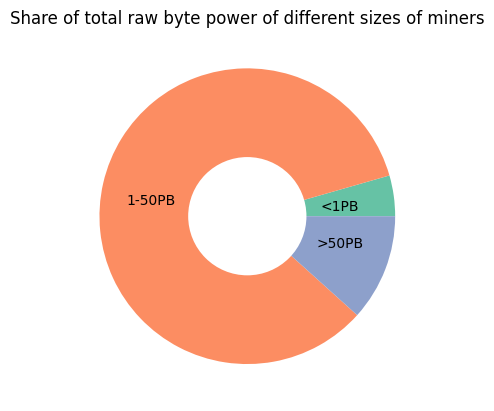

In [ ]:
accumulated_rbp_share = [a / total_rbp_tb for a in accumulated_rbp]
rounded_bins = [ '{0} miners between {1} and {2:1.2f}PB'.format(int(c),k, i,100*j) for c,i,j,k in zip(counts, [1,50,(max(big_miners)/1000)], accumulated_rbp_share, [0,1,50]) ]
plt.pie(x=accumulated_rbp_share, labels=['<1PB', '1-50PB', '>50PB'], labeldistance=0.5, colors=sns.color_palette('Set2'), startangle=0)
hole = plt.Circle((0, 0), 0.4, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title("Share of total raw byte power of different sizes of miners")
plt.show()

In [ ]:
rbp_s = pd.Series(miners_non_zero_raw_byte_power_TB)
print('Summary statistics of raw byte power (in TB) of all miners in the network')
rbp_s.describe()

Summary statistics of raw byte power (in TB) of all miners in the network


count      3376.000000
mean       3481.755471
std        7458.332520
min           0.034360
25%         507.106789
50%        1260.229304
75%        3353.055198
max      103724.765868
dtype: float64

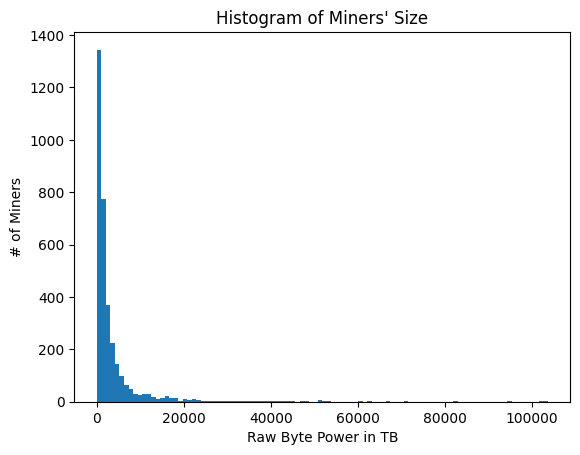

In [ ]:
counts, bins, bars = plt.hist(miners_non_zero_raw_byte_power_TB, bins = 100)
plt.title("Histogram of Miners' Size")
plt.ylabel('# of Miners')
plt.xlabel('Raw Byte Power in TB');
#plt.show()
plt.savefig("miners_size_hist.png")

## Analysis of Filecoin Survey Data

### Sealing Energy Data

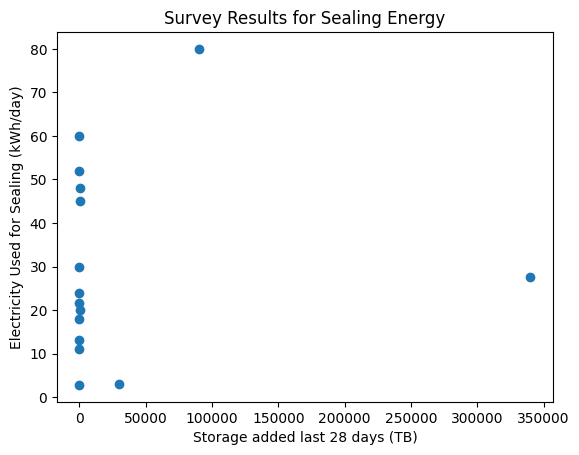

In [ ]:
storage_added_last_28_days_TB = [16.4927, 27.4878, 15, 5.49756, 5.27766, 439.805, 30, 54.9756, 32.9853, 90072, 340022, 30000, 150, 30, 7.69658]
sealing_hardware_energy_kWh_per_day = [18, 24, 30, 2.8, 21.6, 20, 11, 48, 60, 80, 27.6, 3, 45, 52, 13.2]

plt.scatter(storage_added_last_28_days_TB, sealing_hardware_energy_kWh_per_day)
plt.ylabel('Electricity Used for Sealing (kWh/day)')
plt.xlabel('Storage added last 28 days (TB)')
plt.title("Survey Results for Sealing Energy")
plt.show()

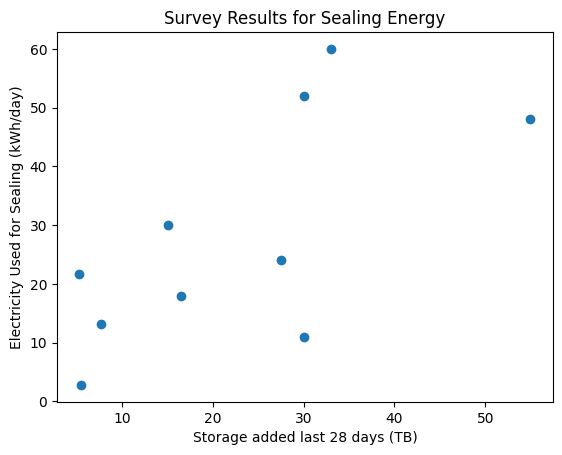

In [ ]:
# outliers removed
storage_added_last_28_days_TB = [16.4927, 27.4878, 15, 5.49756, 5.27766, 30, 54.9756, 32.9853, 30, 7.69658]
sealing_hardware_energy_kWh_per_day = [18, 24, 30, 2.8, 21.6, 11, 48, 60, 52, 13.2]

plt.scatter(storage_added_last_28_days_TB, sealing_hardware_energy_kWh_per_day)
plt.ylabel('Electricity Used for Sealing (kWh/day)')
plt.xlabel('Storage added last 28 days (TB)')
plt.title("Survey Results for Sealing Energy")
plt.show()

In [ ]:
correlation, p_value = pearsonr(storage_added_last_28_days_TB, sealing_hardware_energy_kWh_per_day)
print(correlation)

0.6753416961317709


In [ ]:
x = np.array(storage_added_last_28_days_TB).reshape((-1, 1)) * 1e+12
y = np.array(sealing_hardware_energy_kWh_per_day) * 28000
model = LinearRegression(fit_intercept=False)
model.fit(x, y)

LinearRegression(fit_intercept=False)

In [ ]:
mod = sm.OLS(y,x)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
p_values

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


x1    0.00014
Name: P>|t|, dtype: float64

In [ ]:
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

coefficient of determination: 0.3752922908728329
intercept: 0.0
slope: [3.13278052e-08]


### Storage Energy Data

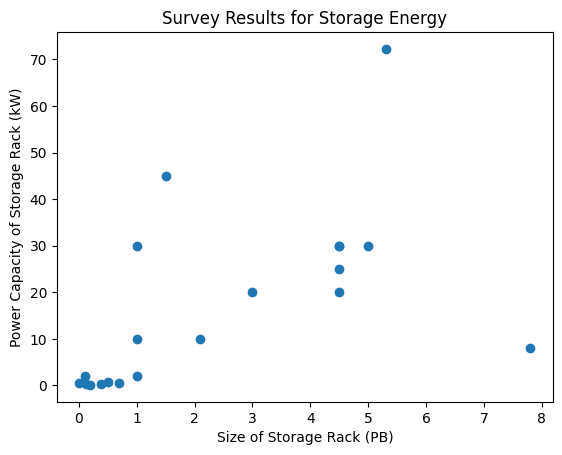

In [ ]:
power_capacity_rack_kW = [0.6, 30, 2, 0.3, 30, 25, 10, 72.27, 0.1, 20, 30, 20, 10, 0.6, 0.8, 0.4, 8, 45, 30, 2]
storage_rack_size_pb = [0.012, 1, 1, 0.384, 4.5, 4.5, 1, 5.3, 0.192, 3, 5, 4.5, 2.1, 0.7, 0.5, 0.12, 7.8, 1.5, 4.5, 0.1]

plt.scatter(storage_rack_size_pb, power_capacity_rack_kW)
plt.ylabel('Power Capacity of Storage Rack (kW)')
plt.xlabel('Size of Storage Rack (PB)')
plt.title("Survey Results for Storage Energy")
plt.show()

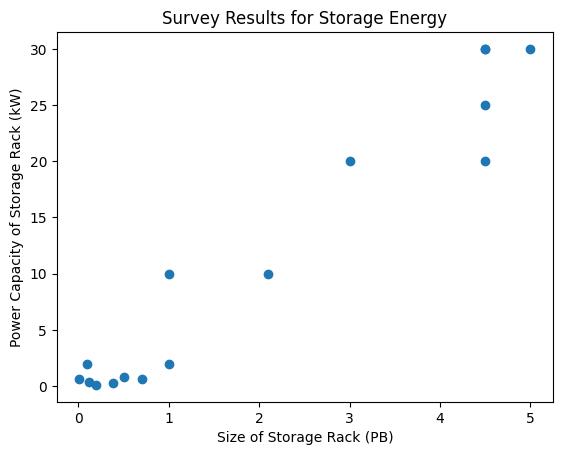

In [ ]:
# obvious outliers removed
power_capacity_rack_kW = [0.6, 2, 0.3, 30, 25, 10, 0.1, 20, 30, 20, 10, 0.6, 0.8, 0.4, 30, 2]
storage_rack_size_pb = [0.012, 1, 0.384, 4.5, 4.5, 1, 0.192, 3, 5, 4.5, 2.1, 0.7, 0.5, 0.12, 4.5, 0.1]

plt.scatter(storage_rack_size_pb, power_capacity_rack_kW)
plt.ylabel('Power Capacity of Storage Rack (kW)')
plt.xlabel('Size of Storage Rack (PB)')
plt.title("Survey Results for Storage Energy")
plt.show()

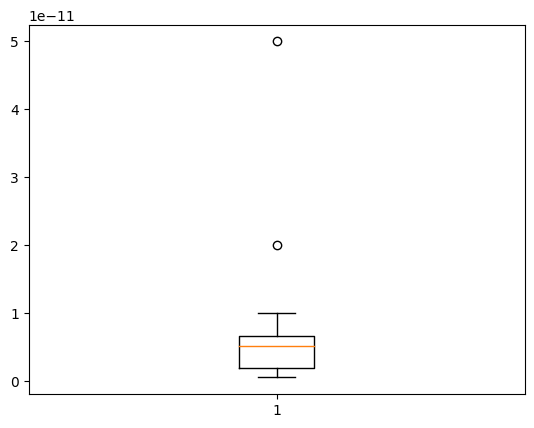

In [ ]:
# boxplot to identify remaining outliers
res = (np.array(power_capacity_rack_kW)*1000) / (np.array(storage_rack_size_pb)*1e+15)
plt.boxplot(res)
plt.show()

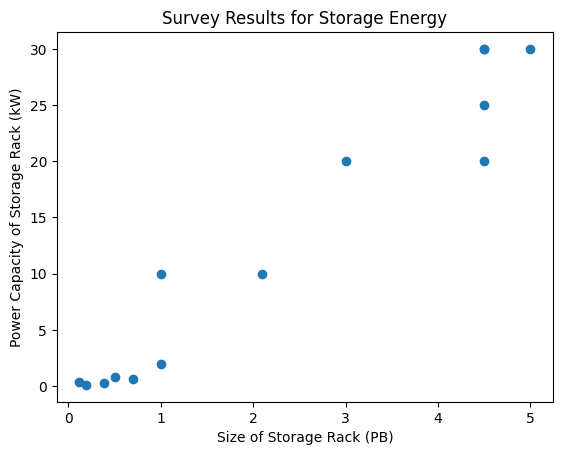

In [ ]:
# all outliers removed
power_capacity_rack_kW = [2, 0.3, 30, 25, 10, 0.1, 20, 30, 20, 10, 0.6, 0.8, 0.4, 30]
storage_rack_size_pb = [1, 0.384, 4.5, 4.5, 1, 0.192, 3, 5, 4.5, 2.1, 0.7, 0.5, 0.12, 4.5]

plt.scatter(storage_rack_size_pb, power_capacity_rack_kW)
plt.ylabel('Power Capacity of Storage Rack (kW)')
plt.xlabel('Size of Storage Rack (PB)')
plt.title("Survey Results for Storage Energy")
plt.show()

In [ ]:
correlation, p_value = pearsonr(power_capacity_rack_kW, storage_rack_size_pb)

print(correlation)

0.9694857335346023


In [ ]:
x = np.array(storage_rack_size_pb).reshape((-1, 1)) * 1e+15
y = np.array(power_capacity_rack_kW) * 1000
model = LinearRegression(fit_intercept=False)
model.fit(x, y)

LinearRegression(fit_intercept=False)

In [ ]:
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

coefficient of determination: 0.9340750112673917
intercept: 0.0
slope: [5.85623127e-12]


In [ ]:
mod = sm.OLS(y,x)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
p_values

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


x1    3.441715e-11
Name: P>|t|, dtype: float64

## Analysis of Data from Filecoin Energy Dashboard & EVP

In [ ]:
def getCapacity(minerId, start_date, end_date):
  url = "https://api.filgreen.d.interplanetary.one/models/export?code_name=SealedModel&miner={}&start={}&end={}".format(minerId, start_date, end_date)
  response = requests.request("GET", url)
  if len(json.loads(response.text)['data']) > 0:
    sealed_df = pd.json_normalize(json.loads(response.text)['data'])
    return np.sum(pd.to_numeric(sealed_df['sealed_GiB']))
  else:
    return 0


In [ ]:
def getCumulativeEnergyUse(minerId, start_date, end_date):
  url = "https://api.filgreen.d.interplanetary.one/models/export?code_name=CumulativeEnergyModel_v_1_0_1&miner={}&start={}&end={}".format(minerId, start_date, end_date)
  response = requests.request("GET", url)
  if len(json.loads(response.text)['data']) > 0:
    energy = (json.loads(response.text)['data'][-1])
    return {'kWh_lower': float(energy['energy_use_kW_lower']), 'kWh_est': float(energy['energy_use_kW_estimate']), 'kWh_upper': float(energy['energy_use_kW_upper'])}
  else:
    return {'kWh_lower': 0.0, 'kWh_est': 0.0, 'kWh_upper': 0.0}

In [ ]:
def getAvgMonthlyCapacity(minerId, start_date, end_date):
  url = "https://api.filgreen.d.interplanetary.one/models/export?code_name=CapacityModel&miner={}&start={}&end={}".format(minerId, start_date, end_date)
  response = requests.request("GET", url)
  if len(json.loads(response.text)['data']) > 0:
    sealed_df = pd.json_normalize(json.loads(response.text)['data'])
    return np.mean(pd.to_numeric(sealed_df['capacity_GiB']))
  else:
    return 0

In [ ]:
def getMonthlyCapAndEnergy(minerIds, start_date, end_date):
  cap = 0
  avg_monthly_cap = 0
  energy = {
    'kWh_lower': 0.0,
    'kWh_est': 0.0,
    'kWh_upper': 0.0
  }
  for id in minerIds:
    cap += getCapacity(id, start_date, end_date)
    avg_monthly_cap += getAvgMonthlyCapacity(id, start_date, end_date)
    energy_mId = getCumulativeEnergyUse(id, start_date, end_date)
    energy['kWh_lower'] += energy_mId['kWh_lower']
    energy['kWh_est'] += energy_mId['kWh_est']
    energy['kWh_upper'] += energy_mId['kWh_upper']
  return cap, energy, avg_monthly_cap

### Anonymous SP

#### Anonymous SP Storage Capacity

In [ ]:
anon_miner_ids = ['f066596', 'f0678914', 'f01652333', 'f01662356', 'f01702940', 'f01732188', 'f01732189', 'f01755793', 'f01756173', 'f01760317', 'f01796026', 'f01814973', 'f01823202', 'f01833311', 'f01851060', 'f01851683', 'f01852564', 'f01862225', 'f01862229', 'f01862232', 'f01868116', 'f01870967', 'f01871315', 'f01872281', 'f01872883', 'f01873364', 'f01873432', 'f01880776', 'f01905085', 'f01912098', 'f01912516', 'f01916574', 'f01890497', 'f01900409']
capacity_df = pd.DataFrame()
for id in anon_miner_ids:
  url = "https://api.filgreen.d.interplanetary.one/models/export?code_name=CapacityModel&miner={}&start=2022-02-01&end=2022-12-31&filter=week".format(id)
  response = requests.request("GET", url)
  if len(json.loads(response.text)['data']) > 0:
    capacity = pd.json_normalize(json.loads(response.text)['data'])
    capacity_df[id] = pd.to_numeric(capacity['capacity_GiB'])

capacity_df['date'] = pd.to_datetime(capacity['start_date'])


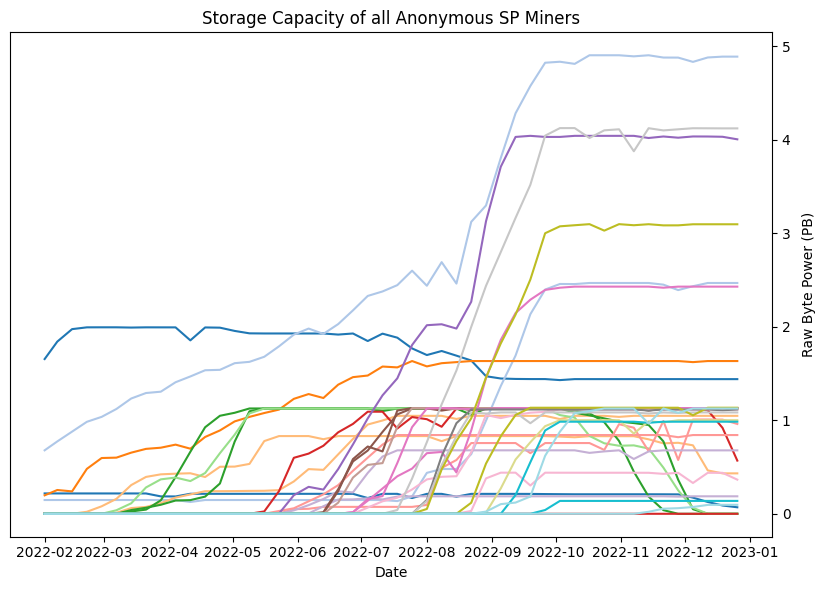

In [ ]:
plt.figure(figsize=(9,6))
color = iter(cm.tab20(np.linspace(0, 1, len(anon_miner_ids))))

for id in anon_miner_ids:
  if id in capacity_df.columns:
    c = next(color)
    plt.plot(capacity_df['date'], capacity_df[id]/931300, linestyle ='solid', label=id, c=c)
    plt.gcf().autofmt_xdate

#plt.legend(loc = 'upper left')
plt.tick_params(axis='y', which='both', labelleft=False, labelright=True, left=False, right=True)
plt.title("Storage Capacity of all Anonymous SP Miners")
plt.ylabel('Raw Byte Power (PB)', labelpad=-580)
plt.xlabel('Date')
plt.tight_layout()
plt.show()

#### Anonymous SP Energy Comparisons

In [ ]:
anon_monthly_cap_added = []
anon_monthly_energy_pred = []
anon_monthly_avg_cap = []
anon_monthly_kWh = [3298, 40420, 66106, 102208, 151055, 174010, 194610, 200488, 153434, 152660, 101779]

In [ ]:
anon_cap_energy_feb = getMonthlyCapAndEnergy(anon_miner_ids, '2022-02-01', '2022-02-28')
anon_monthly_cap_added.append(anon_cap_energy_feb[0])
anon_monthly_energy_pred.append(anon_cap_energy_feb[1])
anon_monthly_avg_cap.append(anon_cap_energy_feb[2])

In [ ]:
anon_cap_energy_mar = getMonthlyCapAndEnergy(anon_miner_ids, '2022-03-01', '2022-03-31')
anon_monthly_cap_added.append(anon_cap_energy_mar[0])
anon_monthly_energy_pred.append(anon_cap_energy_mar[1])
anon_monthly_avg_cap.append(anon_cap_energy_mar[2])

In [ ]:
anon_cap_energy_apr = getMonthlyCapAndEnergy(anon_miner_ids, '2022-04-01', '2022-04-30')
anon_monthly_cap_added.append(anon_cap_energy_apr[0])
anon_monthly_energy_pred.append(anon_cap_energy_apr[1])
anon_monthly_avg_cap.append(anon_cap_energy_apr[2])

In [ ]:
anon_cap_energy_may = getMonthlyCapAndEnergy(anon_miner_ids, '2022-05-01', '2022-05-31')
anon_monthly_cap_added.append(anon_cap_energy_may[0])
anon_monthly_energy_pred.append(anon_cap_energy_may[1])
anon_monthly_avg_cap.append(anon_cap_energy_may[2])

In [ ]:
anon_cap_energy_jun = getMonthlyCapAndEnergy(anon_miner_ids, '2022-06-01', '2022-06-30')
anon_monthly_cap_added.append(anon_cap_energy_jun[0])
anon_monthly_energy_pred.append(anon_cap_energy_jun[1])
anon_monthly_avg_cap.append(anon_cap_energy_jun[2])

In [ ]:
anon_cap_energy_jul = getMonthlyCapAndEnergy(anon_miner_ids, '2022-07-01', '2022-07-31')
anon_monthly_cap_added.append(anon_cap_energy_jul[0])
anon_monthly_energy_pred.append(anon_cap_energy_jul[1])
anon_monthly_avg_cap.append(anon_cap_energy_jul[2])

In [ ]:
anon_cap_energy_aug = getMonthlyCapAndEnergy(anon_miner_ids, '2022-08-01', '2022-08-31')
anon_monthly_cap_added.append(anon_cap_energy_aug[0])
anon_monthly_energy_pred.append(anon_cap_energy_aug[1])
anon_monthly_avg_cap.append(anon_cap_energy_aug[2])

In [ ]:
anon_cap_energy_sep = getMonthlyCapAndEnergy(anon_miner_ids, '2022-09-01', '2022-09-30')
anon_monthly_cap_added.append(anon_cap_energy_sep[0])
anon_monthly_energy_pred.append(anon_cap_energy_sep[1])
anon_monthly_avg_cap.append(anon_cap_energy_sep[2])

In [ ]:
anon_cap_energy_oct = getMonthlyCapAndEnergy(anon_miner_ids, '2022-10-01', '2022-10-31')
anon_monthly_cap_added.append(anon_cap_energy_oct[0])
anon_monthly_energy_pred.append(anon_cap_energy_oct[1])
anon_monthly_avg_cap.append(anon_cap_energy_oct[2])

In [ ]:
anon_cap_energy_nov = getMonthlyCapAndEnergy(anon_miner_ids, '2022-11-01', '2022-11-30')
anon_monthly_cap_added.append(anon_cap_energy_nov[0])
anon_monthly_energy_pred.append(anon_cap_energy_nov[1])
anon_monthly_avg_cap.append(anon_cap_energy_nov[2])

In [ ]:
anon_cap_energy_dec = getMonthlyCapAndEnergy(anon_miner_ids, '2022-12-01', '2022-12-31')
anon_monthly_cap_added.append(anon_cap_energy_dec[0])
anon_monthly_energy_pred.append(anon_cap_energy_dec[1])
anon_monthly_avg_cap.append(anon_cap_energy_dec[2])

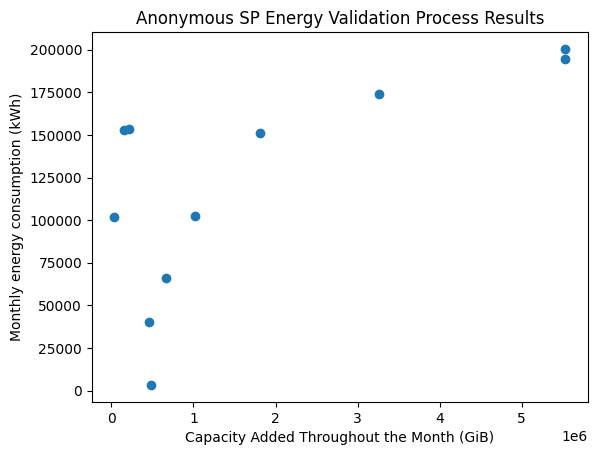

In [ ]:
plt.scatter(anon_monthly_cap_added, anon_monthly_kWh)
plt.xlabel('Capacity Added Throughout the Month (GiB)')
plt.ylabel('Monthly energy consumption (kWh)')
plt.title("Anonymous SP Energy Validation Process Results")
plt.show()

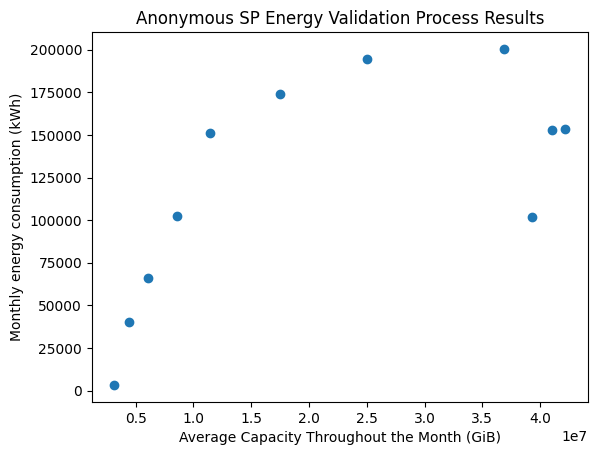

In [ ]:
plt.scatter(anon_monthly_avg_cap, anon_monthly_kWh)
plt.xlabel('Average Capacity Throughout the Month (GiB)')
plt.ylabel('Monthly energy consumption (kWh)')
plt.title("Anonymous SP Energy Validation Process Results")
plt.show()

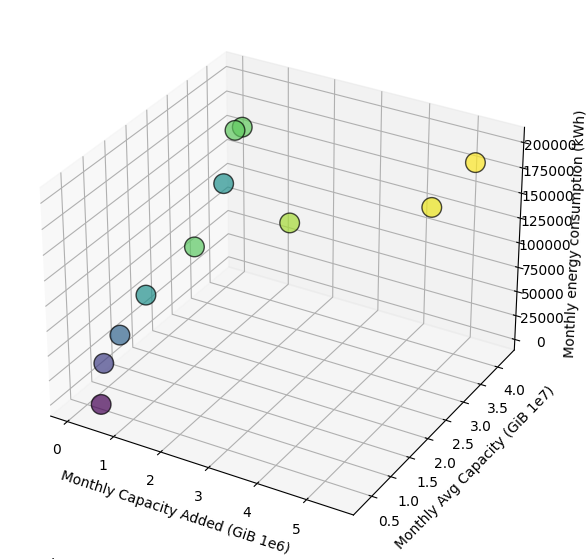

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(anon_monthly_cap_added, anon_monthly_avg_cap, anon_monthly_kWh,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=anon_monthly_kWh)

ax.set_xlabel('Monthly Capacity Added (GiB 1e6)', fontsize=10)
ax.set_ylabel('Monthly Avg Capacity (GiB 1e7)')
ax.set_zlabel('Monthly energy consumption (kWh)')
plt.show()

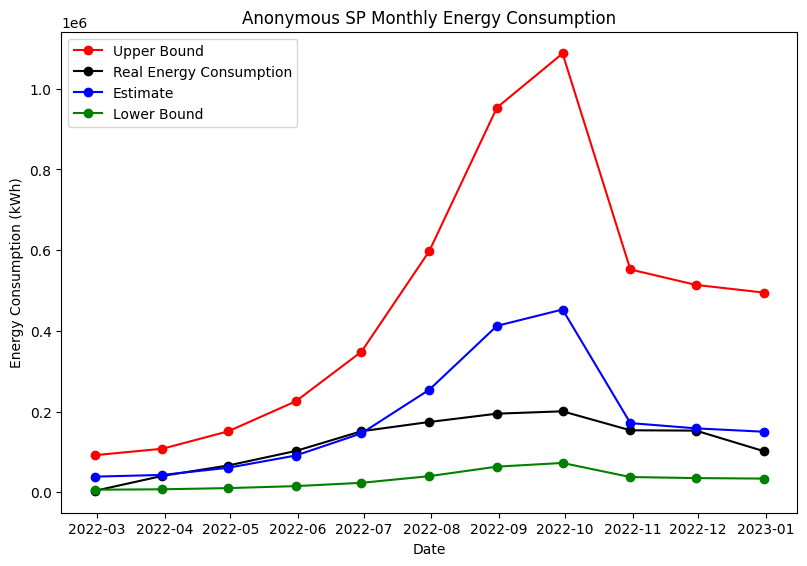

In [ ]:
plt.figure(figsize=(8,5.5))
anon_monthly_energy_pred_df = pd.DataFrame.from_records(anon_monthly_energy_pred)
dates = [
    datetime(2022, 2, 28),
    datetime(2022, 3, 31),
    datetime(2022, 4, 30),
    datetime(2022, 5, 31),
    datetime(2022, 6, 30),
    datetime(2022, 7, 31),
    datetime(2022, 8, 31),
    datetime(2022, 9, 30),
    datetime(2022, 10, 31),
    datetime(2022, 11, 30),
    datetime(2022, 12, 31)
]
plt.plot_date(dates, anon_monthly_energy_pred_df['kWh_upper'], linestyle ='solid', label='Upper Bound', c='r')
plt.plot_date(dates, anon_monthly_kWh, linestyle ='solid', label='Real Energy Consumption', c='k')
plt.plot_date(dates, anon_monthly_energy_pred_df['kWh_est'], linestyle ='solid', label='Estimate', c='b')
plt.plot_date(dates, anon_monthly_energy_pred_df['kWh_lower'], linestyle ='solid', label='Lower Bound', c='g')
plt.tight_layout()
plt.legend(loc = 'upper left')
plt.title("Anonymous SP Monthly Energy Consumption")
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Date')
plt.show()

In [ ]:
num_days = [28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

In [ ]:
monthly_kWh = anon_monthly_kWh
# calculate electrical power in watts by converting monthly consumption in kWh to Wh and dividing by the number of hours in a month
electrical_power = np.array([(m * 1000) / (24 * d) for m, d in zip(monthly_kWh, num_days)])
monthly_cap_added = anon_monthly_cap_added
# calculate sealing rate in bytes/hour by converting monthly capacity added from GiB to bytes and divide by number of hours in a month to
sealing_rate = [(m * 1.074e+9) / (24 * d) for m, d in zip(monthly_cap_added, num_days)]
monthly_avg_cap = anon_monthly_avg_cap
# calculate raw capacity from GiB to bytes
raw_capacity = [m * 1.074e+9 for m in monthly_avg_cap]

In [ ]:
# a PUE of 1.3 was chosen based on SP information
y = electrical_power / 1.3
x = np.column_stack((sealing_rate, raw_capacity))

In [ ]:
model = LinearRegression(fit_intercept=False).fit(x, y)
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"coefficients: {model.coef_}")

coefficient of determination: 0.6472981273886533
intercept: 0.0
coefficients: [1.63817381e-08 3.20727496e-12]


In [ ]:
mod = sm.OLS(y,x)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [ ]:
print(p_values, fii.params)

x1    0.003133
x2    0.000302
Name: P>|t|, dtype: float64 [1.63817381e-08 3.20727496e-12]
